In [1]:
# Install scQuint
# In Google Colab, it might ask you to restart the runtime after installation
!pip install -U git+https://github.com/songlab-cal/scquint.git

In [2]:
%%capture
# Download processed intron count data
!wget https://figshare.com/ndownloader/files/27696714 -O adata_spl.h5ad

In [3]:
%%capture
# Download gene annotation
!wget --no-check-certificate https://ftp.ensembl.org/pub/release-102/gtf/mus_musculus/Mus_musculus.GRCm38.102.chr.gtf.gz

In [4]:
import anndata
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from umap import UMAP

from scquint.data import add_gene_annotation, group_introns, filter_min_cells_per_feature, filter_min_cells_per_intron_group, calculate_PSI
from scquint.differential_splicing import run_differential_splicing, run_differential_splicing_for_each_group, find_marker_introns, mask_PSI
from scquint.dimensionality_reduction.pca import run_pca

/global/software/sl-7.x86_64/modules/langs/python/3.7/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
# Load preprocessed intron counts
adata = anndata.read_h5ad("adata_spl.h5ad")

# These steps only needed because this data was prepared with older code
adata.var = adata.var[["chromosome", "start", "end", "strand", "annotated"]]
adata.var.end -= 1  # to match the coordinates from this gene annotation
adata.var.index = adata.var.chromosome.astype(str) + ":" + adata.var.start.astype(str) + "-" + adata.var.end.astype(str)
adata = add_gene_annotation(adata, "Mus_musculus.GRCm38.102.chr.gtf.gz")
adata = group_introns(adata, by="three_prime")

adata

/global/software/sl-7.x86_64/modules/langs/python/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:8: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  


Filtering to introns associated to 1 and only 1 gene.


/global/scratch/projects/fc_songlab/gbenegas/projects/scquint/scquint/data.py:129: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["gene_id"] = adata.var.gene_id_list


Filtering singletons.
Filtering intron groups associated with more than 1 gene.


/global/scratch/projects/fc_songlab/gbenegas/.local/lib/python3.7/site-packages/pandas/core/generic.py:5516: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value


AnnData object with n_obs × n_vars = 44518 × 29924
    obs: 'FACS.selection', 'age', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'sex', 'subtissue', 'tissue', 'n_genes', 'n_counts', 'louvain', 'leiden', 'cell_type', 'plate_id'
    var: 'chromosome', 'start', 'end', 'strand', 'annotated', 'gene_id_start', 'gene_id_end', 'n_genes', 'gene_id', 'gene_name', 'intron_group', 'intron_group_size', 'n_genes_per_intron_group'

In [6]:
# Metadata associated to each cell
adata.obs

,FACS.selection,age,cell,cell_ontology_class,cell_ontology_id,free_annotation,method,mouse.id,sex,subtissue,tissue,n_genes,n_counts,louvain,leiden,cell_type,plate_id
my_id,,,,,,,,,,,,,,,,,
A10_B000126,NaN,3m,A10.B000126.3_39_F.1.1,bulge keratinocyte,CL:0002337,nan,facs,3_39_F,female,Telogen,Skin,2552,339047.0,10,9,bulge_keratinocyte,B000126
A10_B000127,NaN,3m,A10.B000127.3_38_F.1.1,myeloid cell,CL:0000763,nan,facs,3_38_F,female,Fat,SCAT,1785,254953.0,16,16,myeloid_cell,B000127
A10_B000166,NaN,3m,A10.B000166.3_56_F.1.1,basal cell,CL:0000646,basal cell,facs,3_56_F,female,Mammary_Gland,Mammary_Gland,4713,2246909.0,22,20,basal_cell,B000166
A10_B000610,NaN,3m,A10.B000610.3_56_F.1.1,bladder urothelial cell,CL:1001428,nan,facs,3_56_F,female,nan,Bladder,4182,1486054.0,28,26,bladder_urothelial_cell,B000610
A10_B000633,NaN,3m,A10.B000633.3_56_F.1.1,endothelial cell of coronary artery,CL:0000115,coronary vascular endothelial cell,facs,3_56_F,female,RV,Heart,2001,448241.0,3,3,endothelial_cell_of_coronary_artery,B000633
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
P9_MAA001887,NaN,3m,P9.MAA001887.3_39_F.1.1,hematopoietic stem cell,CL:0002035,MPP Fraction B + C,facs,3_39_F,female,KLS,Marrow,2919,227378.0,8,8,hematopoietic_stem_cell,MAA001887
P9_MAA001888,NaN,3m,P9.MAA001888.3_39_F.1.1,"CD4-positive, alpha-beta T cell",CL:0000815,BM CD4 T cell,facs,3_39_F,female,T-cells,Marrow,1960,171978.0,7,7,"CD4_positive,_alpha_beta_T_cell",MAA001888
P9_MAA001889,NaN,3m,P9.MAA001889.3_38_F.1.1,B cell,CL:0000236,B,facs,3_38_F,female,EPCAM,Lung,1622,427794.0,1,1,B_cell,MAA001889


In [7]:
# Metadata associated to each intron/splice junction
adata.var

,chromosome,start,end,strand,annotated,gene_id_start,gene_id_end,n_genes,gene_id,gene_name,intron_group,intron_group_size,n_genes_per_intron_group
Sox17_chr1:4492669-4493099,chr1,4492669,4493099,-,True,ENSMUSG00000025902,ENSMUSG00000025902,1,ENSMUSG00000025902,Sox17,Sox17_chr1_4492669_-,2,1
Sox17_chr1:4492669-4493771,chr1,4492669,4493771,-,True,ENSMUSG00000025902,ENSMUSG00000025902,1,ENSMUSG00000025902,Sox17,Sox17_chr1_4492669_-,2,1
Mrpl15_chr1:4774517-4776409,chr1,4774517,4776409,-,False,ENSMUSG00000033845,,1,ENSMUSG00000033845,Mrpl15,Mrpl15_chr1_4774517_-,2,1
Mrpl15_chr1:4774517-4777524,chr1,4774517,4777524,-,True,ENSMUSG00000033845,ENSMUSG00000033845,1,ENSMUSG00000033845,Mrpl15,Mrpl15_chr1_4774517_-,2,1
Mrpl15_chr1:4777649-4778747,chr1,4777649,4778747,-,False,ENSMUSG00000033845,,1,ENSMUSG00000033845,Mrpl15,Mrpl15_chr1_4777649_-,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
Arhgap6_chrX:169036867-169220197,chrX,169036867,169220197,+,True,ENSMUSG00000031355,ENSMUSG00000031355,1,ENSMUSG00000031355,Arhgap6,Arhgap6_chrX_169220197_+,2,1
Mid1_chrX:169685373-169926953,chrX,169685373,169926953,+,True,ENSMUSG00000035299,ENSMUSG00000035299,1,ENSMUSG00000035299,Mid1,Mid1_chrX_169926953_+,2,1
Mid1_chrX:169879910-169926953,chrX,169879910,169926953,+,True,ENSMUSG00000035299,ENSMUSG00000035299,1,ENSMUSG00000035299,Mid1,Mid1_chrX_169926953_+,2,1
Eif2s3y_chrY:1012170-1014633,chrY,1012170,1014633,+,True,ENSMUSG00000069049,ENSMUSG00000069049,1,ENSMUSG00000069049,Eif2s3y,Eif2s3y_chrY_1014633_+,2,1


In [8]:
# Filtering to heart cells
adata = adata[adata.obs.tissue=="Heart"]
adata = filter_min_cells_per_feature(adata, 100)
adata = filter_min_cells_per_intron_group(adata, 100)
adata.shape

filter_min_cells_per_feature
filter_singletons
filter_min_cells_per_intron_group
filter_singletons


(4433, 3044)

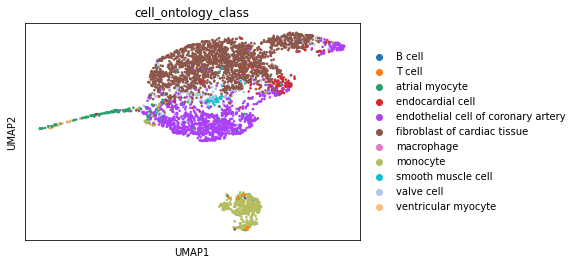

In [9]:
# Obtaining a low dimensional visualization based on alternative splicing
adata.obsm["X_umap"] = UMAP(n_components=2).fit_transform(run_pca(adata, 10))
sc.pl.umap(adata, color='cell_ontology_class')

In [10]:
adata.obs.cell_ontology_class.value_counts()

fibroblast of cardiac tissue           2118
endothelial cell of coronary artery    1179
monocyte                                490
endocardial cell                        164
atrial myocyte                          159
valve cell                              158
smooth muscle cell                       65
ventricular myocyte                      46
T cell                                   37
B cell                                   15
macrophage                                2
Name: cell_ontology_class, dtype: int64

In [11]:
groups_test = adata.obs.cell_ontology_class.value_counts()[:6].head(6).index.tolist()
groups_test

['fibroblast of cardiac tissue',
 'endothelial cell of coronary artery',
 'monocyte',
 'endocardial cell',
 'atrial myocyte',
 'valve cell']

In [12]:
diff_spl_intron_groups, diff_spl_introns = run_differential_splicing_for_each_group(
    adata, "cell_ontology_class", groups=groups_test, subset_to_groups=True,
    min_cells_per_intron_group=50, min_total_cells_per_intron=50,
    n_jobs=-1,  # -1 means use all cores
    # It will run much faster on a machine with multiple cores than in Colab
)

fibroblast of cardiac tissue
sample sizes:  2118 2150
(4268, 3044)
filter_min_cells_per_feature
filter_singletons
(4268, 3044)
filter_min_global_proportion
filter_singletons
(4268, 3023)
filter_min_cells_per_intron_group
filter_singletons
filter_min_cells_per_intron_group
filter_singletons
(4268, 2871)
Number of intron groups:  1359
Number of introns:  2871


100%|██████████| 1359/1359 [00:14<00:00, 91.45it/s] 


endothelial cell of coronary artery
sample sizes:  1179 3089
(4268, 3044)
filter_min_cells_per_feature
filter_singletons
(4268, 3044)
filter_min_global_proportion
filter_singletons
(4268, 3023)
filter_min_cells_per_intron_group
filter_singletons
filter_min_cells_per_intron_group
filter_singletons
(4268, 2445)
Number of intron groups:  1148
Number of introns:  2445


100%|██████████| 1148/1148 [00:05<00:00, 226.85it/s]


monocyte
sample sizes:  490 3778
(4268, 3044)
filter_min_cells_per_feature
filter_singletons
(4268, 3044)
filter_min_global_proportion
filter_singletons
(4268, 3023)
filter_min_cells_per_intron_group
filter_singletons
filter_min_cells_per_intron_group
filter_singletons
(4268, 1894)
Number of intron groups:  889
Number of introns:  1894


100%|██████████| 889/889 [00:04<00:00, 216.72it/s]


endocardial cell
sample sizes:  164 4104
(4268, 3044)
filter_min_cells_per_feature
filter_singletons
(4268, 3044)
filter_min_global_proportion
filter_singletons
(4268, 3023)
filter_min_cells_per_intron_group
filter_singletons
filter_min_cells_per_intron_group
filter_singletons
(4268, 964)
Number of intron groups:  448
Number of introns:  964


100%|██████████| 448/448 [00:02<00:00, 164.00it/s]


atrial myocyte
sample sizes:  159 4109
(4268, 3044)
filter_min_cells_per_feature
filter_singletons
(4268, 3044)
filter_min_global_proportion
filter_singletons
(4268, 3023)
filter_min_cells_per_intron_group
filter_singletons
filter_min_cells_per_intron_group
filter_singletons
(4268, 729)
Number of intron groups:  338
Number of introns:  729


100%|██████████| 338/338 [00:01<00:00, 235.75it/s]


valve cell
sample sizes:  158 4110
(4268, 3044)
filter_min_cells_per_feature
filter_singletons
(4268, 3044)
filter_min_global_proportion
filter_singletons
(4268, 3023)
filter_min_cells_per_intron_group
filter_singletons
filter_min_cells_per_intron_group
filter_singletons
(4268, 852)
Number of intron groups:  394
Number of introns:  852


100%|██████████| 394/394 [00:02<00:00, 194.10it/s]


In [13]:
sig_diff_spl_intron_groups = diff_spl_intron_groups.query('p_value_adj < 0.05 and max_abs_delta_psi > 0.05')
sig_diff_spl_intron_groups.shape

(1335, 12)

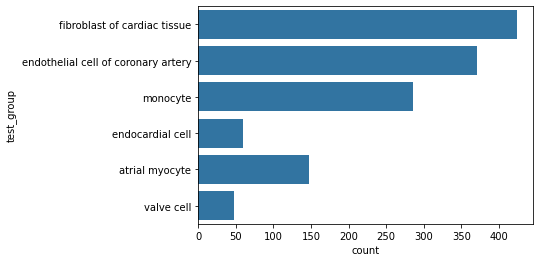

In [14]:
# Number of significant events per cell type
sns.countplot(sig_diff_spl_intron_groups, y="test_group", color="C0", order=groups_test);

In [15]:
# Calculate PSI (intron proportions) from intron counts
# This is expected to contain lots of nan's
adata.layers["PSI_raw"] = calculate_PSI(adata)

/global/scratch/projects/fc_songlab/gbenegas/projects/scquint/scquint/data.py:203: RuntimeWarning: invalid value encountered in true_divide
  return X / intron_group_sums[:,groups]


In [16]:
marker_introns = find_marker_introns(
    diff_spl_intron_groups, diff_spl_introns, n=10, min_delta_psi=0.3,
)
marker_introns = {c: marker_introns[c] for c in groups_test} # just reordering
marker_introns

{'fibroblast of cardiac tissue': ['Fmo1_chr1:162859563-162859800',
  'S100a16_chr3:90537418-90541993',
  'Arhgef2_chr3:88616655-88629786',
  'Lims2_chr18:31931551-31941739',
  'Sh3kbp1_chrX:159840612-159865324',
  'Lmo2_chr2:103969722-103970492',
  'Nav1_chr1:135472872-135510203',
  'Sdr39u1_chr14:55899921-55900267',
  'Pola2_chr19:5951787-5953064',
  'Steap3_chr1:120244268-120258760'],
 'endothelial cell of coronary artery': ['Fbln2_chr6:91257827-91263338',
  'Arhgef3_chr14:27238154-27265522',
  'Arhgap10_chr8:77259210-77276816',
  'Rapgef1_chr2:29643915-29679132',
  'Lipe_chr7:25388654-25390061',
  'Akap12_chr10:4334710-4353141',
  'Utrn_chr10:12765333-12813445',
  'Myo1c_chr11:75650765-75657491',
  'Arhgef1_chr7:24918001-24919630',
  'C1qtnf1_chr11:118433903-118443691'],
 'monocyte': ['Lsp1_chr7:142460967-142484478',
  'Mbnl1_chr3:60473174-60528755',
  'Ntpcr_chr8:125733232-125736067',
  'P2ry6_chr7:100940019-100964218',
  'Arap1_chr7:101393630-101394733',
  'Nsfl1c_chr2:151500790-1

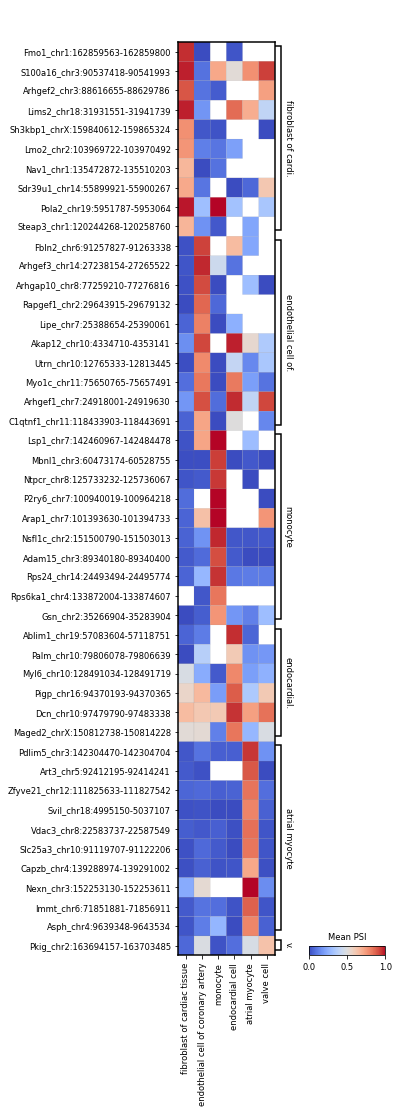

In [17]:
sc.pl.matrixplot(
    # we want to mask introns with less than min_cells=10 cells with defined PSI
    # to reduce noise in the heatmap visualization
    mask_PSI(
        adata[adata.obs.cell_ontology_class.isin(groups_test)],
        marker_introns, "cell_ontology_class", min_cells=10
    ),
    marker_introns, 'cell_ontology_class', cmap='coolwarm', categories_order=groups_test,
    swap_axes=True, layer="PSI_raw_masked", colorbar_title="Mean PSI", vmin=0, vmax=1,
)

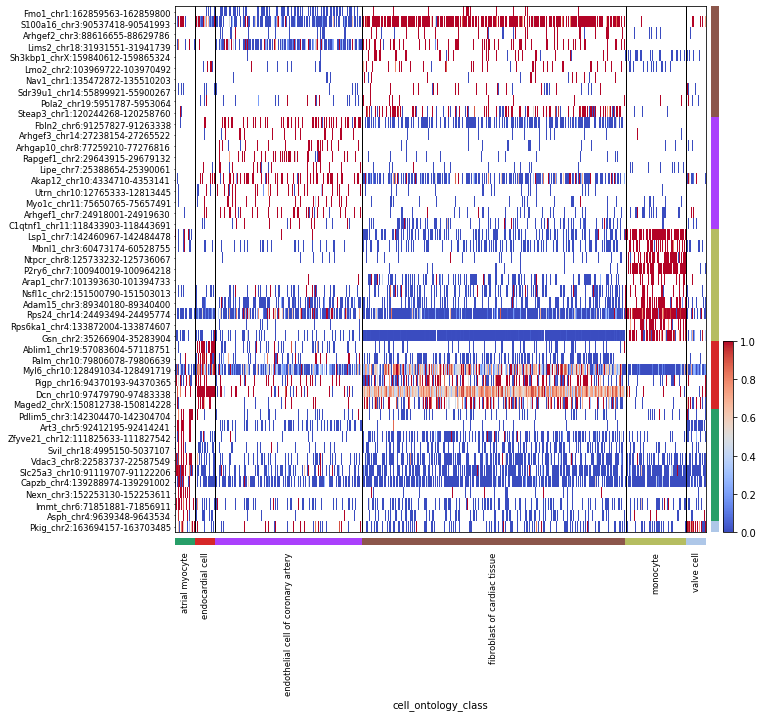

In [18]:
sc.pl.heatmap(
    mask_PSI(
        adata[adata.obs.cell_ontology_class.isin(groups_test)],
        marker_introns, "cell_ontology_class", min_cells=10
    ),
    marker_introns,
    'cell_ontology_class',
    cmap='coolwarm',
    # categories_order=groups_test,  # not working for some reason
    swap_axes=True,
    layer="PSI_raw_masked",
    vmin=0,
    vmax=1,
    figsize=(10, 10),
)

In [19]:
# The results can be further visualized with 
# the cellxgene browser https://scquint.ds.czbiohub.org/tabula-muris/
# and UCSC Genome Browser https://genome.ucsc.edu/s/gbenegas/tabulamuris